In [29]:
import pyterrier as pt  # type: ignore
from src.load_index import setup_system

import matplotlib.pyplot as plt
import seaborn as sns 
import os
import pandas as pd
import yaml  # type: ignore

import numpy as np

In [25]:
with open("settings.yml", "r") as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)

In [22]:
index, topics, qrels = setup_system("WT")
train_topics, validation_topics, test_topics = np.split(
    topics, [int(0.6 * len(topics)), int(0.8 * len(topics))]
)

Loaded index with  1570734 documents.


In [23]:
def get_qrels(train_topics, validation_topics, test_topics, qrels):
    def filter_ids(topics):
        needed_ids = list(topics["qid"].unique())  # needed ids
        qrels_split = qrels[qrels["qid"].isin(needed_ids)]
        diff = len(needed_ids) - len(qrels_split["qid"].unique())
        return qrels_split
    
    train_qrels = filter_ids(train_topics)
    validation_qrels = filter_ids(validation_topics)
    test_qrels = filter_ids(test_topics)
    return train_qrels, validation_qrels, test_qrels

def get_runs(run_names: str):
    runs = []
    names = []
    runs_dir = "results/trec"

    for run_name in run_names:
        runs.append(pt.io.read_results(os.path.join(runs_dir, run_name)))
        names.append(run_name)
    
    return runs, names

In [20]:
train_qrels, validation_qrels, test_qrels = get_qrels(train_topics, validation_topics, test_topics, qrels)

In [27]:
runs, names = get_runs(["IRCologne-BM25.WT", "IRCologne-RRF(BBXP).WT"])

results = pt.Experiment(
    runs,
    topics[topics["qid"].isin(config["top_runs"])],
    qrels,
    names = names,
    eval_metrics=["ndcg"],
    perquery=True,
)

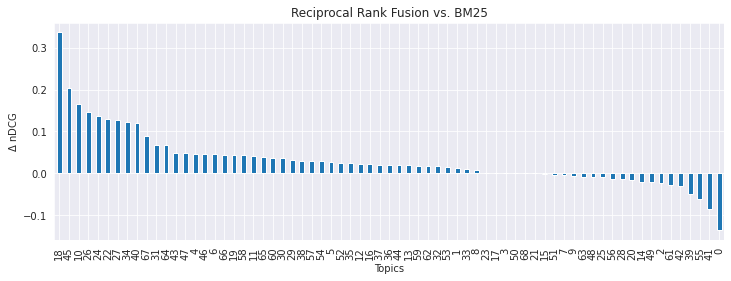

In [40]:
pivot_results = pd.pivot_table(results, values = 'value', index=['qid'], columns = 'name').reset_index()
pivot_results["delta"] = pivot_results["IRCologne-RRF(BBXP).WT"] - pivot_results["IRCologne-BM25.WT"]
ax = pivot_results['delta'].sort_values(ascending=False).plot(figsize=(12,4), kind='bar')
ax.set_xlabel("Topics")
ax.set_ylabel('$\Delta$ nDCG')
plt.title("Reciprocal Rank Fusion vs. BM25")
plt.show()